# 1. Genetic Algorithm with DEAP #

Подгружаем необходимые библиотеки

In [59]:
from deap import tools, base
from numpy import random as rnd
import numpy as np
from deap import creator
from deap import benchmarks
from deap.algorithms import eaMuPlusLambda
from functools import partial
#Для отрисовки функции
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

## 1.1 Задача поиска экстремума сложной функции

Creator - метафабрика классов позволяющая создавать классы, которые будут удовлетворять потребности ваших эволюционных алгоритмов. 

Note: weights=(-1.0,) - minimization, weights=(1.0,) - maximization

In [60]:
creator.create("BaseFitness", base.Fitness, weights=(-1.0,)) 
creator.create("Individual", np.ndarray, fitness=creator.BaseFitness)

D:\Soft\anaconda3\envs\practice\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'BaseFitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
D:\Soft\anaconda3\envs\practice\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Инициализируем целевую функцию 

In [61]:
optimization_function = benchmarks.rastrigin

Нарисуем ее

In [62]:
def function_drawing(func, limit):

    def function_arg0(selected_function, sol):
        return selected_function(sol)[0]

    function_for_drawing = partial(function_arg0, func)

    fig = plt.figure()
    ax = Axes3D(fig, azim = -29, elev = 40)
    X = np.arange(limit[0], limit[1], 0.5)
    Y = np.arange(limit[0], limit[1], 0.5)
    X, Y = np.meshgrid(X, Y)
    Z = np.fromiter(map(function_for_drawing, zip(X.flat,Y.flat)), dtype=np.float, count=X.shape[0]*X.shape[1]).reshape(X.shape)

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet, linewidth=0.2)

    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()

In [63]:
dimension = 3
pop_size = 100
iterations = 100
mut_prob = 0.6
cross_prob = 0.3
limit = [-5, 5]

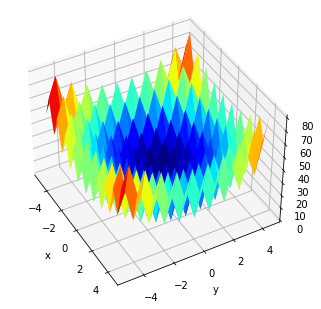

In [64]:
function_drawing(optimization_function, limit)

Зададим параметры нашего жволюционного алгоритма
* dimension - размерность задачи
* pop_size - размер популяции
* iterations - количество поколений 
* mut_prob - вероятность применения оператора мутации
* cross_prob - вероятность применения оператора скрещивания к двум отобранным индивидам
* limit - область поиска по каждой из переменых функции

Функция для инициализации случайного числа из выбранной области определения:

In [65]:
def factory(limit, dimension):
    return limit[0] + rnd.random(dimension) * (limit[1]-limit[0])

In [66]:
class DrawLog:
    @staticmethod
    def read_log(log):
        avg_list, std_list, min_list, max_list, gen_list = [list() for i in range(5)]
        for g in log:
            avg_list.append(g['avg'])
            std_list.append(g['std'])
            min_list.append(g['min'])
            max_list.append(g['max'])
            gen_list.append(g['gen'])
        return np.array(gen_list), np.array(avg_list), np.array(std_list), np.array(max_list), np.array(min_list)
    
    @staticmethod
    def draw_log(log):
        gen_list, avg_list, std_list, max_list, min_list = DrawLog.read_log(log)
        plt.plot(gen_list, avg_list, label="avg")
        plt.plot(gen_list, min_list, label="min")
        plt.plot(gen_list, max_list, label="max")
        plt.fill_between(gen_list, avg_list-std_list, avg_list+std_list, alpha=0.2)
        plt.ylabel('Fitness')
        plt.xlabel('Generation, #')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    @staticmethod
    def draw_logs(log1, log2, lab1, lab2):
        gen1, avg1, std1, max1, min1 = DrawLog.read_log(log1)
        gen2, avg2, std2, max2, min2 = DrawLog.read_log(log2)
        plt.plot(gen1, avg1, label=lab1, color="blue")
        plt.plot(gen1, max1, label="{}_max".format(lab1), color="purple", linewidth=2)
        plt.fill_between(gen1, avg1 - std1, avg1 + std1, alpha=0.2, color="blue")
        plt.plot(gen2, avg2, label=lab2, color="orange")
        plt.plot(gen2, max2, label="{}_max".format(lab2), color="red", linewidth=2)
        plt.fill_between(gen2, avg2 - std2, avg2 + std2, alpha=0.2, color="orange")
        plt.ylabel('Fitness')
        plt.xlabel('Generation, #')
        plt.legend()
        plt.tight_layout()
        plt.show()

## Генетический алгоритм реализованный посредствам Deap

Все основные объекты, которые мы будем использовать на нашем пути: индивид, популяция, а также все функции, операторы и аргументы будут храниться в контейнере DEAP с именем Toolbox. 

Он содержит два метода добавления и удаления содержимого register()и unregister().

**В конструкторе класса GeneticAlgorithm** мы регистрируем две функции инициализации individual() и population(). 

Здесь, в inidividual:
* tools.initIterate - инидивид наследуется от какого-то итеративного(iterable) объекта (например list).
* creator.Individual - тип объекта который создается
* ind_gener_func - функция при помощи которой инициализируется случайный объект

В population:
* tools.initRepeat - способ инициализации контейнера популяции
* list - тип контейнера
* toolbox.individual - какой функцией инициализируется объект-индивид
* pop_size - сколько индивидов необходимо создать в популяции

Ниже инициализируются эволюционные операторы.

**В функции run_evolution** происходит создание популяции и определение обсервера – данных для мониторинга, далее происходит запуск эволюционного процесса.

In [67]:
class GeneticAlgorithm:
    def __init__(self, factory, function,  pop_size=50, limit=limit, dimension=dimension,crossover=tools.cxOnePoint,\
                 mutation=partial(tools.mutGaussian, mu=0, sigma=0.5, indpb=0.2), \
                 selection = partial(tools.selTournament, tournsize=4)):
        self.toolbox = base.Toolbox()
        self.pop_size = pop_size
        # Structure initializers
        ind_gener_func = partial(factory, limit, dimension)
        self.toolbox.register("individual", tools.initIterate, creator.Individual, ind_gener_func)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual, pop_size)
        #genetic operators
        self.toolbox.register("mate", crossover) #crossover
        self.toolbox.register("mutate", mutation)
        self.toolbox.register("select", selection)
        self.toolbox.register("evaluate",function)
    
    def run_evolution(self, cross_prob, mut_prob, iterations, verbose = True):
        pop = self.toolbox.population() #инициализация начальной популяции
        hof = tools.HallOfFame(3, np.array_equal) #хранятся лучшие решения, архив
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)
        pop, log = eaMuPlusLambda(pop, self.toolbox, mu=self.pop_size, lambda_=int(pop_size*0.8), cxpb=cross_prob, mutpb=mut_prob,
                              ngen=iterations, stats=stats, halloffame=hof, verbose=True)
        print("Best individual = {}".format(hof[0]))
        print("Best fitness = {}".format(hof[0].fitness.values[0]))
        if verbose:
            DrawLog.draw_log(log)
        return pop, log

Инициализация генетического алгоритма

In [68]:
ga = GeneticAlgorithm(factory, optimization_function, pop_size, limit, dimension)

Запуск генетического алгоритма

gen	nevals	avg    	std    	min    	max    
0  	100   	52.5498	17.4581	16.3637	98.5013
1  	74    	38.078 	10.1216	17.9445	59.3652
2  	74    	28.3335	5.35041	17.6457	44.9439
3  	71    	21.7404	5.3908 	5.38529	30.6912
4  	71    	17.0879	3.96076	5.21803	24.8547
5  	70    	12.6659	3.58663	5.21803	23.5472
6  	75    	9.35525	3.18103	3.626  	16.5862
7  	70    	6.44861	2.02216	3.626  	11.3286
8  	72    	5.27123	0.56181	3.626  	8.22449
9  	77    	4.76153	0.761402	3.37963	5.38529
10 	70    	3.99894	0.669355	3.37963	5.21803
11 	67    	3.53441	0.189052	2.04953	3.626  
12 	70    	3.27757	0.569794	1.25759	3.626  
13 	74    	3.12228	0.627587	1.25759	3.626  
14 	67    	2.58072	0.915029	1.16638	3.37963
15 	66    	1.76352	0.688385	1.16638	3.31568
16 	70    	1.36562	0.290033	1.1067 	3.31568
17 	70    	1.22293	0.0476989	1.1067 	1.25759
18 	67    	1.16788	0.0484439	1.1067 	1.25759
19 	77    	1.12368	0.0273082	1.10243	1.16638
20 	70    	1.10668	0.00869875	1.10243	1.16638
21 	70    	1.10294	0.00866943	1.04345

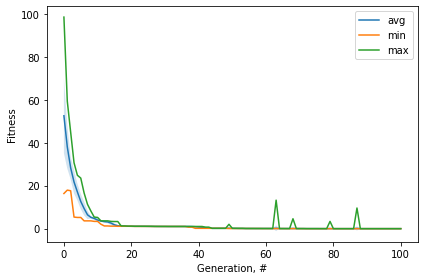

In [69]:
population, log = ga.run_evolution(cross_prob, mut_prob, iterations)

Протестируем наш алгоритм на другой функции.

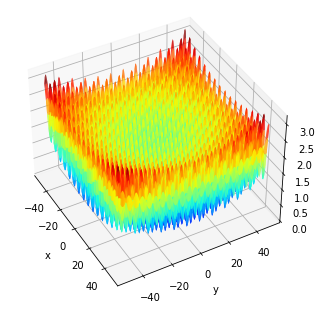

In [70]:
iterations = 200
pop_size = 200
mut_prob = 0.9
cross_prob = 0.1
optimization_function = benchmarks.griewank
function_drawing(optimization_function, limit=[-50, 50])

gen	nevals	avg    	std     	min      	max    
0  	200   	1.03837	0.348531	0.0779916	1.96083
1  	160   	0.685095	0.262274	0.0382418	1.15239
2  	160   	0.36502 	0.183056	0.0382418	0.81937
3  	160   	0.193022	0.100359	0.0259024	0.496298
4  	160   	0.100344	0.0527884	0.0190186	0.312687
5  	160   	0.0617324	0.0218175	0.0218382	0.168872
6  	160   	0.04463  	0.014361 	0.018987 	0.0798572
7  	160   	0.0323486	0.00772664	0.018987 	0.0667796
8  	160   	0.0256725	0.00409179	0.0165066	0.0428391
9  	160   	0.0228737	0.00253919	0.0165066	0.040108 
10 	160   	0.0202338	0.00235871	0.00893753	0.0253578
11 	160   	0.0182149	0.00514075	0.00893753	0.0763936
12 	160   	0.0155949	0.00350728	0.00771215	0.019112 
13 	160   	0.0126594	0.00330699	0.00752433	0.018987 
14 	160   	0.00994785	0.00239392	0.00750057	0.0174176
15 	160   	0.00846043	0.0010815 	0.00750057	0.0137829
16 	160   	0.00775584	0.000391887	0.00746787	0.00893753
17 	160   	0.00783295	0.00320119 	0.00745894	0.0497993 
18 	160   	0.00750795	2.6507

159	160   	0.00739607	0          	0.00739607	0.00739607
160	160   	0.00747513	0.00111534 	0.00739607	0.023209  
161	160   	0.00739609	2.17007e-07	0.00739607	0.00739915
162	160   	0.00739607	0          	0.00739607	0.00739607
163	160   	0.00739607	0          	0.00739607	0.00739607
164	160   	0.00739607	0          	0.00739607	0.00739607
165	160   	0.00739607	0          	0.00739607	0.00739607
166	160   	0.00765332	0.0036289  	0.00739607	0.0588453 
167	160   	0.00745126	0.000778572	0.00739607	0.0184344 
168	160   	0.0075281 	0.00146986 	0.00739607	0.0271927 
169	160   	0.00739607	0          	0.00739607	0.00739607
170	160   	0.00739607	0          	0.00739607	0.00739607
171	160   	0.00739607	0          	0.00739607	0.00739607
172	160   	0.00744433	0.000586922	0.00739607	0.0155968 
173	160   	0.00739607	0          	0.00739607	0.00739607
174	160   	0.00739607	0          	0.00739607	0.00739607
175	160   	0.00739607	0          	0.00739607	0.00739607
176	160   	0.00749161	0.00134781 	0.00739607	0.0

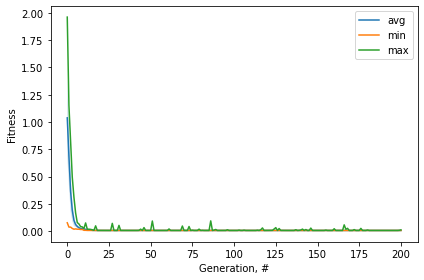

In [71]:
ga = GeneticAlgorithm(factory, optimization_function, pop_size)
population, log = ga.run_evolution(cross_prob, mut_prob, iterations)

Увеличим область поиска

gen	nevals	avg    	std     	min     	max   
0  	200   	1.01469	0.310106	0.153945	1.9771
1  	160   	0.696056	0.244576	0.153945	1.14745
2  	160   	0.453666	0.187068	0.102669	0.904038
3  	160   	0.279933	0.121788	0.0225621	0.618457
4  	160   	0.16849 	0.0643013	0.00477361	0.376088
5  	160   	0.104654	0.051649 	0.00477361	0.209508
6  	160   	0.057341	0.0408873	0.00477361	0.161564
7  	160   	0.0242236	0.0205371	0.00133481	0.128138
8  	160   	0.0123371	0.00877164	0.00133481	0.0606517
9  	160   	0.00638617	0.00343326	0.000191925	0.0166546
10 	160   	0.00357509	0.00195654	1.57204e-05	0.0104695
11 	160   	0.00222196	0.00173739	1.57204e-05	0.0104695
12 	160   	0.00100204	0.000669651	1.57204e-05	0.00477361
13 	160   	0.000479637	0.000426663	1.57204e-05	0.00133481
14 	160   	0.000189046	0.000189837	1.57204e-05	0.00133481
15 	160   	6.48528e-05	7.41092e-05	1.57204e-05	0.000191925
16 	160   	2.37972e-05	3.28206e-05	1.02751e-05	0.000191925
17 	160   	1.97849e-05	6.21456e-05	1.02751e-05	0.000896274
18

161	160   	3.53162e-07	0          	3.53162e-07	3.53162e-07
162	160   	9.80259e-06	0.000133301	3.53162e-07	0.00189024 
163	160   	3.53162e-07	0          	3.53162e-07	3.53162e-07
164	160   	3.53162e-07	0          	3.53162e-07	3.53162e-07
165	160   	9.77258e-05	0.00137361 	3.53162e-07	0.0194749  
166	160   	3.53162e-07	0          	3.53162e-07	3.53162e-07
167	160   	3.53162e-07	0          	3.53162e-07	3.53162e-07
168	160   	3.53162e-07	0          	3.53162e-07	3.53162e-07
169	160   	3.53162e-07	0          	3.53162e-07	3.53162e-07
170	160   	3.53162e-07	0          	3.53162e-07	3.53162e-07
171	160   	3.53162e-07	0          	3.53162e-07	3.53162e-07
172	160   	3.53162e-07	0          	3.53162e-07	3.53162e-07
173	160   	3.53162e-07	0          	3.53162e-07	3.53162e-07
174	160   	3.53162e-07	0          	3.53162e-07	3.53162e-07
175	160   	5.12072e-06	6.72547e-05	3.53162e-07	0.000953865
176	160   	3.53162e-07	0          	3.53162e-07	3.53162e-07
177	160   	3.53162e-07	0          	3.53162e-07	3.53162e-

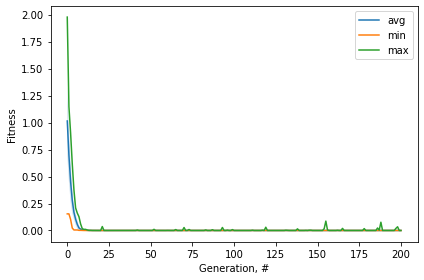

In [72]:
limit = [-100, 100]
ga = GeneticAlgorithm(factory, optimization_function, pop_size)
population, log = ga.run_evolution(cross_prob, mut_prob, iterations)

При увеличении размерности задачи так же будет наблюдаться ухудшение качества поиска. Это означает то, что в данном случае требуется задать другие более подходящие гиперпараметры (в первую очередь увеличить размер популяции и количество поколений для поиска), что позволит получить хорошее решение в изменившихся условиях.

gen	nevals	avg    	std      	min     	max    
0  	700   	1.01955	0.0156384	0.855248	1.11249
1  	560   	1.00714	0.0215065	0.874286	1.02923
2  	560   	0.988034	0.0335921	0.832269	1.01945
3  	560   	0.9522  	0.0444631	0.804347	1.01153
4  	560   	0.899705	0.0438453	0.688336	0.987423
5  	560   	0.849184	0.0415247	0.660566	0.948728
6  	560   	0.801727	0.046217 	0.547357	0.884314
7  	560   	0.753405	0.0503586	0.547357	0.839188
8  	560   	0.694283	0.0492314	0.489215	0.804347
9  	560   	0.636983	0.0575235	0.348927	0.757531
10 	560   	0.57503 	0.0641854	0.334568	0.68475 
11 	560   	0.508008	0.0689988	0.191892	0.655162
12 	560   	0.436459	0.0711851	0.191892	0.602359
13 	560   	0.362351	0.0591382	0.172958	0.520452
14 	560   	0.30404 	0.0561872	0.164689	0.436603
15 	560   	0.245032	0.0527552	0.107694	0.362799
16 	560   	0.197069	0.0353269	0.0697387	0.336163
17 	560   	0.167052	0.025661 	0.0697387	0.242336
18 	560   	0.142959	0.026609 	0.0681851	0.247959
19 	560   	0.117719	0.0226359	0.0565926	0.188

159	560   	0.000257548	0.00500092 	1.83552e-06	0.13046  
160	560   	0.000148733	0.00152294 	1.83552e-06	0.0229555
161	560   	0.000414976	0.00371861 	1.83552e-06	0.0662992
162	560   	0.000230748	0.00257003 	1.83552e-06	0.0511626
163	560   	0.000363627	0.00473298 	1.83552e-06	0.0957957
164	560   	0.000175614	0.00232878 	1.83552e-06	0.0472078
165	560   	0.0002261  	0.002687   	1.83552e-06	0.0586377
166	560   	0.000140366	0.00207273 	1.73482e-06	0.0472925
167	560   	0.000154924	0.00178886 	1.73482e-06	0.0392975
168	560   	0.000168636	0.00149822 	1.73482e-06	0.0251952
169	560   	0.000128138	0.00135686 	1.73482e-06	0.0230626
170	560   	0.000135715	0.00243828 	1.73482e-06	0.0583135
171	560   	0.000118604	0.00146133 	1.73482e-06	0.0294238
172	560   	5.1711e-05 	0.000794916	1.73482e-06	0.0193701
173	560   	0.000136986	0.0014612  	1.73482e-06	0.0289437
174	560   	0.000325678	0.00511988 	1.73482e-06	0.123115 
175	560   	0.000228247	0.00289763 	1.73482e-06	0.066887 
176	560   	0.000254671	0.003111

305	560   	0.000126968	0.00137708 	1.32395e-07	0.0216655
306	560   	0.00021526 	0.00187668 	1.32395e-07	0.0314353
307	560   	0.000420584	0.00469484 	1.32395e-07	0.0907724
308	560   	0.000188922	0.00168782 	1.32395e-07	0.0254363
309	560   	0.00045057 	0.00653338 	1.32395e-07	0.159312 
310	560   	4.36955e-05	0.000732771	1.32395e-07	0.0177369
311	560   	0.000211413	0.00237683 	1.32395e-07	0.0473939
312	560   	0.000153335	0.00154672 	1.32395e-07	0.0259166
313	560   	0.000396716	0.00414249 	1.32395e-07	0.0720023
314	560   	0.000288953	0.00269506 	1.32395e-07	0.0400275
315	560   	9.40535e-05	0.00135004 	1.32395e-07	0.0277288
316	560   	0.000130578	0.00155774 	1.32395e-07	0.0335483
317	560   	0.000167208	0.00166577 	1.32395e-07	0.0280325
318	560   	5.80196e-05	0.000646412	1.32395e-07	0.0117767
319	560   	0.000221966	0.00310588 	1.32395e-07	0.0748138
320	560   	0.000271811	0.00248332 	1.32395e-07	0.0319595
321	560   	0.000175471	0.00217096 	1.32395e-07	0.0477457
322	560   	0.000194396	0.002080

448	560   	0.000280644	0.00296848 	8.95186e-08	0.0483244 
449	560   	0.000184899	0.00273641 	8.95186e-08	0.0601382 
450	560   	0.000153158	0.00211408 	8.95186e-08	0.0476029 
451	560   	0.000215897	0.00255948 	8.95186e-08	0.047261  
452	560   	0.000294631	0.00434718 	8.95186e-08	0.0893961 
453	560   	6.25867e-05	0.000858933	8.95186e-08	0.0186798 
454	560   	0.000212549	0.00251493 	8.95186e-08	0.057902  
455	560   	0.000218214	0.00229704 	8.03873e-08	0.0380495 
456	560   	0.000415609	0.00433258 	8.03873e-08	0.0705587 
457	560   	0.000235799	0.00214948 	8.03873e-08	0.0285625 
458	560   	7.74374e-05	0.000919807	7.39801e-08	0.0192322 
459	560   	0.000131452	0.0017005  	7.39801e-08	0.0297279 
460	560   	0.000129682	0.00146417 	7.39801e-08	0.0317297 
461	560   	0.000262102	0.00303253 	7.39801e-08	0.0537908 
462	560   	0.000343243	0.00352911 	7.39801e-08	0.0721918 
463	560   	0.000199689	0.0027275  	7.39801e-08	0.0619639 
464	560   	0.000510981	0.00779314 	7.39801e-08	0.197173  
465	560   	0.0

600	560   	0.000107632	0.00089797 	5.08838e-08	0.0131445 
601	560   	0.000192274	0.00179581 	5.08838e-08	0.0273845 
602	560   	0.000132208	0.00144134 	5.08838e-08	0.0246891 
603	560   	0.000128892	0.00237222 	5.08838e-08	0.0617763 
604	560   	0.000502766	0.00467811 	5.08838e-08	0.0822119 
605	560   	0.000220329	0.0021777  	5.0721e-08 	0.0330413 
606	560   	0.000162127	0.00148663 	5.02183e-08	0.0187711 
607	560   	0.000241143	0.00277302 	5.0122e-08 	0.052483  
608	560   	0.000270992	0.00241701 	5.0122e-08 	0.0398147 
609	560   	0.000116926	0.00247104 	5.0122e-08 	0.0642088 
610	560   	0.00023342 	0.00232399 	5.0122e-08 	0.0423883 
611	560   	0.000161166	0.00168995 	5.0122e-08 	0.0229832 
612	560   	0.000200616	0.00256233 	4.99592e-08	0.0587652 
613	560   	0.000270573	0.00259373 	4.99592e-08	0.048023  
614	560   	0.000109964	0.00129326 	4.99592e-08	0.0258822 
615	560   	0.000184295	0.00199381 	4.99592e-08	0.0421679 
616	560   	0.000324741	0.00279449 	4.99592e-08	0.0438858 
617	560   	0.0

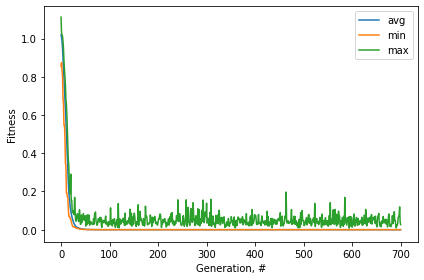

In [73]:
limit = [-5, 5]
dimension = 10
iterations = 700
pop_size = 700
ga = GeneticAlgorithm(factory, optimization_function, pop_size, limit=limit, dimension=dimension)
population, log = ga.run_evolution(cross_prob, mut_prob, iterations)

Мы можем воспользоваться другими генетическими операторами из Deap. 
**Попробуем задать другую функцию скрещивания.**

gen	nevals	avg    	std      	min     	max   
0  	700   	1.02046	0.0140683	0.882498	1.0809
1  	560   	1.00713	0.0225642	0.838169	1.02803
2  	560   	0.986857	0.0368723	0.808468	1.01961
3  	560   	0.949623	0.0483755	0.808468	1.01302
4  	560   	0.894489	0.0486247	0.728727	0.996284
5  	560   	0.841929	0.0412117	0.689649	0.966609
6  	560   	0.795277	0.0441496	0.500038	0.886084
7  	560   	0.745822	0.0500689	0.500038	0.851256
8  	560   	0.687703	0.0571788	0.444456	0.793592
9  	560   	0.615471	0.0641294	0.349246	0.748016
10 	560   	0.547643	0.0600389	0.291373	0.684037
11 	560   	0.483274	0.0614477	0.213445	0.604208
12 	560   	0.415202	0.0677153	0.213445	0.551818
13 	560   	0.345416	0.0634278	0.135468	0.506838
14 	560   	0.280725	0.0499422	0.11589 	0.424587
15 	560   	0.231068	0.0452074	0.0937824	0.383035
16 	560   	0.185601	0.0386782	0.0815478	0.309799
17 	560   	0.151627	0.0325439	0.05661  	0.228549
18 	560   	0.120151	0.025499 	0.0329176	0.200485
19 	560   	0.0985158	0.0214976	0.0329176	0.227

151	560   	4.32431e-05	0.000449199	8.22381e-06	0.00682476
152	560   	0.000170709	0.00153807 	8.22381e-06	0.0292984 
153	560   	0.000435557	0.0040693  	4.65362e-06	0.0647937 
154	560   	4.5032e-05 	0.00041754 	4.65362e-06	0.00617833
155	560   	0.00015909 	0.00154694 	4.65362e-06	0.0278489 
156	560   	0.000406234	0.00419832 	4.65362e-06	0.0905822 
157	560   	0.000594968	0.00569963 	4.64748e-06	0.0913583 
158	560   	0.000118038	0.00129617 	4.64748e-06	0.0260402 
159	560   	0.000424798	0.00559755 	4.58918e-06	0.137568  
160	560   	0.000368645	0.00441648 	4.48413e-06	0.101592  
161	560   	0.000153549	0.00158451 	4.48413e-06	0.0304444 
162	560   	0.000297385	0.00312837 	4.48413e-06	0.0709207 
163	560   	9.22894e-05	0.000852103	4.47799e-06	0.0120835 
164	560   	0.000271358	0.00268449 	4.243e-06  	0.0522513 
165	560   	0.00019731 	0.00210229 	4.243e-06  	0.0450235 
166	560   	0.000224212	0.0022594  	4.243e-06  	0.0400327 
167	560   	0.00023392 	0.00236205 	4.1847e-06 	0.0357025 
168	560   	0.0

293	560   	0.000144272	0.00164856 	1.76419e-07	0.0271626 
294	560   	0.000131289	0.00153924 	1.76419e-07	0.0291543 
295	560   	0.000334088	0.00367728 	1.76419e-07	0.0757909 
296	560   	0.000279844	0.00328837 	1.76419e-07	0.0700604 
297	560   	0.000301574	0.00256578 	1.76419e-07	0.0422435 
298	560   	0.00035438 	0.00424163 	1.76419e-07	0.0825948 
299	560   	8.02897e-05	0.00104321 	1.76419e-07	0.0217593 
300	560   	8.79185e-05	0.0011364  	1.76419e-07	0.023854  
301	560   	0.000228235	0.00264819 	1.76419e-07	0.0573146 
302	560   	0.000268494	0.002452   	1.27152e-07	0.0385622 
303	560   	0.000133745	0.00147413 	1.27152e-07	0.0292604 
304	560   	0.000179588	0.00282619 	1.27152e-07	0.0703656 
305	560   	0.000234103	0.00261868 	1.27152e-07	0.0466817 
306	560   	0.000161858	0.0014949  	1.27152e-07	0.021157  
307	560   	0.000123953	0.00196407 	1.27152e-07	0.0370534 
308	560   	0.000271983	0.00341697 	1.27152e-07	0.0665882 
309	560   	9.74437e-05	0.00133825 	1.27152e-07	0.0289063 
310	560   	0.0

439	560   	0.000145641	0.00194928 	3.21963e-08	0.0444677 
440	560   	0.000200201	0.00165573 	3.21963e-08	0.0192545 
441	560   	0.000163953	0.00248763 	3.21963e-08	0.0625786 
442	560   	0.000245288	0.00275896 	3.21963e-08	0.0473608 
443	560   	0.000299282	0.00402829 	3.21963e-08	0.0987246 
444	560   	8.30851e-05	0.000892609	3.21963e-08	0.0143827 
445	560   	4.03266e-05	0.000524872	3.21963e-08	0.00961837
446	560   	0.000121949	0.00173781 	3.21963e-08	0.0402712 
447	560   	0.000150022	0.00182192 	3.21963e-08	0.0409488 
448	560   	0.000253019	0.00219473 	3.21963e-08	0.0319947 
449	560   	0.000237229	0.00293627 	3.21963e-08	0.0589424 
450	560   	0.000245402	0.00319597 	3.21963e-08	0.0753217 
451	560   	0.000296487	0.00280794 	3.21963e-08	0.0449333 
452	560   	0.00030729 	0.00366682 	3.21963e-08	0.0607669 
453	560   	0.000243638	0.00283568 	3.21963e-08	0.0562089 
454	560   	0.000270949	0.0031225  	3.21963e-08	0.0632347 
455	560   	0.000102419	0.0011676  	3.21963e-08	0.0218869 
456	560   	0.0

583	560   	0.000191311	0.00190738 	1.77712e-08	0.0302091 
584	560   	0.000157845	0.00166771 	1.77712e-08	0.0321538 
585	560   	0.000117159	0.00127505 	1.77712e-08	0.0223319 
586	560   	0.000207803	0.00243591 	1.77712e-08	0.0457353 
587	560   	0.000252799	0.00290666 	1.77712e-08	0.0653562 
588	560   	0.000175119	0.00190316 	1.77712e-08	0.0395271 
589	560   	0.000178683	0.00211423 	1.77712e-08	0.0467901 
590	560   	0.000281389	0.00248072 	1.77712e-08	0.0345784 
591	560   	0.00012044 	0.00143043 	1.77712e-08	0.0252764 
592	560   	0.000108231	0.00131176 	1.77712e-08	0.0246666 
593	560   	0.000127405	0.00187637 	1.77712e-08	0.0459244 
594	560   	0.000139465	0.00175996 	1.77712e-08	0.0347544 
595	560   	0.000301765	0.00265271 	1.77712e-08	0.0392866 
596	560   	0.00015253 	0.00163536 	1.77712e-08	0.0272032 
597	560   	0.000218519	0.00252877 	1.77712e-08	0.0476334 
598	560   	0.000217436	0.00295523 	1.77712e-08	0.0709662 
599	560   	6.64796e-05	0.000699965	1.77712e-08	0.00916184
600	560   	0.0

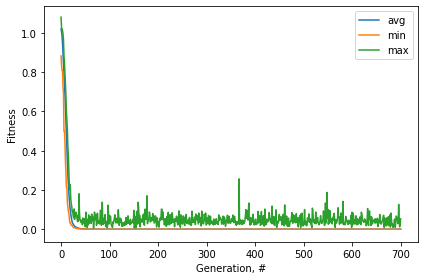

In [74]:
#выберем двухточеченое скрещивание
crossover = tools.cxTwoPoint
ga = GeneticAlgorithm(factory, optimization_function, pop_size, crossover = crossover, dimension=dimension)
population, log = ga.run_evolution(cross_prob, mut_prob, iterations)

## Использование собственных генетических операторов.

Реализация собственного оператора мутации

In [75]:
def Mymutation(individual):
    n = len(individual)
    for i in range(n):
        if rnd.random() < n * 0.15:
            individual[i] += rnd.normal(0.0, 0.2)
            individual[i] = np.clip(individual[i], -5, 5)
    return individual,

Передадим его в алгоритм в качестве параметра

gen	nevals	avg    	std     	min     	max    
0  	300   	1.00967	0.129754	0.510556	1.73363
1  	240   	0.901409	0.114067	0.510556	1.03448
2  	240   	0.773193	0.124662	0.473584	1.0013 
3  	240   	0.62629 	0.109675	0.425027	0.888439
4  	240   	0.500198	0.0789651	0.317759	0.721431
5  	240   	0.42206 	0.0708928	0.1874  	0.596569
6  	240   	0.332314	0.0655688	0.171056	0.461742
7  	240   	0.26062 	0.0560773	0.14785 	0.399373
8  	240   	0.202665	0.045977 	0.0956403	0.383436
9  	240   	0.155088	0.0343072	0.0447087	0.246494
10 	240   	0.119368	0.0310614	0.0237553	0.197065
11 	240   	0.0897633	0.0246794	0.0237553	0.171234
12 	240   	0.0674129	0.0211728	0.0237553	0.128198
13 	240   	0.0475178	0.0136593	0.0184221	0.0956403
14 	240   	0.0373476	0.0111125	0.0183426	0.077299 
15 	240   	0.028905 	0.00725382	0.0117271	0.0570872
16 	240   	0.0239327	0.00519511	0.0117271	0.0471494
17 	240   	0.0200334	0.00408939	0.0112261	0.0371745
18 	240   	0.016926 	0.00426952	0.00822036	0.0454598
19 	240   	0.0144225	

151	240   	0.00762654	0.00141788 	0.00740062	0.0223888
152	240   	0.00759589	0.00128041 	0.00740062	0.0232082
153	240   	0.00759558	0.00170554 	0.00740062	0.0264549
154	240   	0.00773564	0.00218094 	0.00740062	0.0354605
155	240   	0.00772406	0.00258869 	0.00740062	0.0423869
156	240   	0.00756184	0.00138555 	0.00740062	0.0245904
157	240   	0.00772666	0.00222877 	0.00740062	0.0319598
158	240   	0.00755529	0.00138648 	0.00740062	0.0232641
159	240   	0.00758779	0.00195459 	0.00740062	0.0366889
160	240   	0.00771163	0.00197648 	0.00740062	0.0259551
161	240   	0.00770054	0.00164302 	0.00740062	0.0221223
162	240   	0.00766143	0.00252471 	0.00740062	0.0445155
163	240   	0.00780804	0.00233005 	0.00740062	0.0260063
164	240   	0.00767612	0.00275041 	0.00740062	0.0496984
165	240   	0.00747534	0.000670217	0.00740062	0.0174012
166	240   	0.0077954 	0.00261434 	0.00740062	0.0372983
167	240   	0.00782892	0.00298122 	0.00740062	0.040859 
168	240   	0.00759084	0.00134762 	0.00740062	0.024455 
169	240   

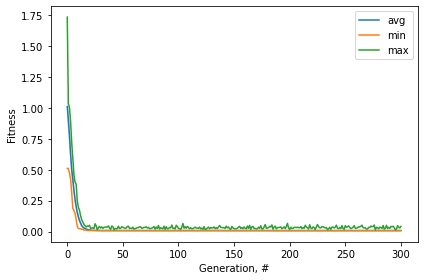

In [76]:
iterations = 300
pop_size = 300
ga = GeneticAlgorithm(factory, optimization_function, pop_size, mutation = Mymutation, dimension=5)
population, log = ga.run_evolution(cross_prob, mut_prob, iterations)

Отлично! Перейдем к следующему разделу

## 1.2 Задача о рюкзаке

**Условие**: из заданного множества предметов со свойствами «стоимость» и «вес» требуется отобрать подмножество с максимальной полной стоимостью и минимальным весом (так же установлено ограничение на суммарный вес рюкзака).

In [77]:
import random
from deap import algorithms

**Инициализация основных параметров/ограничений задачи**
* ind_init_size - количество предметов с которым инициализируются индивиды начальной популяции
* max_item - максимальное количество предметов в рюкзаке
* max_weight - максимальный вес рюкзака
* num_of_items - количество различных предметов

In [78]:
ind_init_size = 5
max_item = 50
max_weight = 50
num_of_items = 20

In [79]:
creator.create("KnapsackFitness", base.Fitness, weights=(-1.0, 1.0))
creator.create("KnapsackIndividual", set, fitness=creator.KnapsackFitness)

D:\Soft\anaconda3\envs\practice\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'KnapsackFitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
D:\Soft\anaconda3\envs\practice\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'KnapsackIndividual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Теперь у вас есть индивиды (которые по сути являются множествами из предметов). 

У каждого из них можно оценить fitness. 

В данном случае цель - это минимизация первой цели (веса мешка) и максимизация второй цели (ценность мешка). 

Мы имеем дело с *многокритериальной задачей комбинаторной оптимизации*.

Теперь мы создадим словарь из 20 случайных предметов, которые и будем складывать в рюкзак:

In [80]:
# Create the item dictionary: item name is an integer, and value is 
# a (weight, value) 2-uple.
items = {}
# Create random items and store them in the items' dictionary.
for i in range(num_of_items):
    items[i] = (random.randint(1, 10), random.uniform(0, 100))

Определим **функцию оценки индивида**.

Здесь рассчитывается суммарный вес и суммарная стоимость (не забываем, что у нас два objectiv-а).

In [81]:
def evalKnapsack(individual):
    weight = 0.0
    value = 0.0
    for item in individual:
        weight += items[item][0]
        value += items[item][1]
    if len(individual) > max_item or weight > max_weight:
        return 10000, 0             # Ensure overweighted bags are dominated
    return weight, value

В Deap нет операторов кроссовера и мутации, которые можно было бы применять непосредственно к наборам. Поэтому придется ввети свои.

**Функция скрещивания**

Определим простой вариант скрещивания порождающий двух детей от двух родителей. И в нашем случае первый ребенок будет получаться пересечением двух множеств, а второй ребенок - их разницей.

Однако для того чтобы не получались пустые индивиды, необходимо прописать некоторые дополнительные условия.

In [82]:
def cxSet(ind1, ind2):
    """Apply a crossover operation on input sets. The first child is the
    intersection of the two sets, the second child is the difference of the
    two sets.
    """
    temp = set(ind1)                # Used in order to keep type
    temp2 = set(ind2)
    ind1 &= ind2                    # Intersection (inplace)
    ind2 ^= temp                    # Symmetric Difference (inplace)x
    if len(ind1) == 0:
        ind1.add(temp.pop())
    if len(ind2) == 0:
        ind2.add(temp2.pop())
    return ind1, ind2

**Оператор мутации** будет случайным образом добавлять или удалять элемент из набора.

In [83]:
def mutSet(individual):
    """Mutation that pops or add an element."""
    if random.random() < 0.5:
        if len(individual) > 1:     # We cannot pop from an empty set
            individual.remove(random.choice(sorted(tuple(individual))))
    else:
        individual.add(random.randrange(num_of_items))
    return individual,

Затем мы регистрируем эти операторы в панели инструментов. 

Поскольку это **многокритериальная задача**, мы выбрали схему селекции **NSGA-II**: selNSGA2()

In [102]:
class NSGA2():
    def __init__(self, evaluation, crossover, mutation):
        self.toolbox = base.Toolbox()
        # Attribute generator
        self.toolbox.register("attr_item", random.randrange, num_of_items)
        # Structure initializers
        self.toolbox.register("individual", tools.initRepeat, creator.KnapsackIndividual, self.toolbox.attr_item, ind_init_size)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("evaluate", evaluation)
        self.toolbox.register("mate", cxSet)
        self.toolbox.register("mutate", mutSet)
        self.toolbox.register("select", tools.selNSGA2)
    def run(self, generations = 50, mut_prob=0.3, cross_prob = 0.5, lamb=100, mu = 50):
        random.seed(64)

        pop = self.toolbox.population(n=mu)
        hof = tools.ParetoFront()
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean, axis=0)
        stats.register("std", np.std, axis=0)
        stats.register("min", np.min, axis=0)
        stats.register("max", np.max, axis=0)

        algorithms.eaMuPlusLambda(pop, self.toolbox, mu, lamb, cross_prob, mut_prob, generations, stats,
                                  halloffame=hof)

        return pop, stats, hof

In [103]:
pop, stats, hof =NSGA2(evaluation = evalKnapsack, crossover = cxSet, mutation = mutSet).run()

gen	nevals	avg                        	std                      	min                      	max                        
0  	50    	[ 23.6        196.00986856]	[ 6.06959636 51.74043165]	[ 8.         95.47664715]	[ 33.         318.51587409]
1  	76    	[ 11.56       161.88409067]	[ 9.11736804 95.63738407]	[ 1.         42.13623908]	[ 33.         360.65211317]
2  	77    	[ 10.7        186.64428657]	[ 10.55130324 104.7591043 ]	[ 1.         39.90339593]	[ 35.         368.80830693]
3  	78    	[  6.92       166.23157856]	[  9.74441378 110.84314124]	[ 1.         88.67720677]	[ 42.         414.32080237]
4  	78    	[  8.26       172.45601322]	[ 12.1750729  122.99311207]	[ 1.         88.67720677]	[ 42.         414.32080237]
5  	79    	[  9.22       179.84851161]	[ 12.80670137 128.63018636]	[ 1.         88.67720677]	[ 42.         414.32080237]
6  	75    	[ 10.48       197.02331283]	[ 13.14266335 138.4164302 ]	[ 1.         88.67720677]	[ 35.         457.59015801]
7  	84    	[ 11.08       207.49106908]

In [93]:
weights = []
values = []
for ind in hof:
    w, val = evalKnapsack(ind) 
    weights.append(w)
    values.append(val)

Найденное множество Парето:

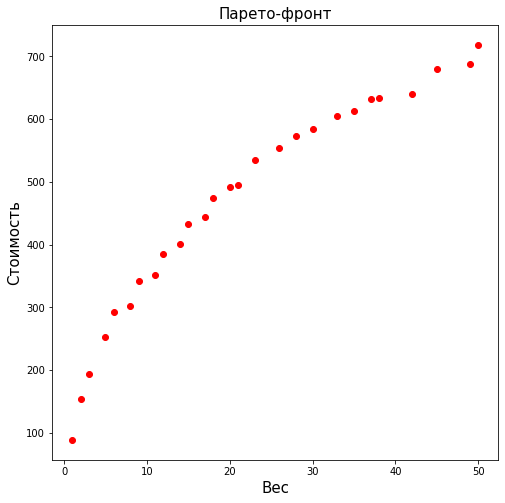

In [99]:
fig, ax = plt.subplots()

ax.scatter(weights, values, c = 'red')  

ax.set_title('Парето-фронт', fontsize = 15)  
plt.ylabel('Стоимость', fontsize = 15)
plt.xlabel('Вес', fontsize = 15)

fig.set_figwidth(8)     
fig.set_figheight(8)    

plt.show()


## 2. Метод роя частиц (PSO) реализованный посредствам Deap

In [107]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", np.ndarray, fitness=creator.BaseFitness, speed=None, smin=None, smax=None, best=None)

* particle_generation - функция инициализации нового индивида

На начальном этапе сам индивид случайным образом инициализируется со случайной скоростью.

* updateParticle - служит для обновления скорости и позиции индивида

In [108]:
class PSOAlgorithm:
    
    def generate(self):
        return rnd.uniform(self.pmin, self.pmax, self.dimension)

    def particle_generation(self):
        particle = tools.initIterate(creator.Particle, self.generate)
        particle.speed = rnd.uniform(self.smin, self.smax, self.dimension)
        particle.smin = self.smin
        particle.smax = self.smax
        return particle

    def updateParticle(self, part, global_best):
        v1 = (part.best - part) * rnd.uniform(0, self.c1)
        v2 = (global_best - part) * rnd.uniform(0, self.c2)
        part.speed = np.clip(part.speed * self.w + v1 + v2, self.smin, self.smax)
        part[:] = np.clip(part[:] + part.speed, self.pmin, self.pmax)

    def __init__(self, pop_size, iterations, dimension, function):
        self.pop_size = pop_size
        self.iterations = iterations
        self.dimension = dimension
        self.function = function
        self.c1 = 0.8
        self.c2 = 0.7
        self.w = 1.0
        self.pmin = -5.0
        self.pmax = 5.0
        self.smin = -2.0
        self.smax = 2.0

        self.toolbox = base.Toolbox()
        self.toolbox.register("particle", self.particle_generation)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.particle)
        self.toolbox.register("update", self.updateParticle)
        self.toolbox.register("evaluate", self.function)

    def run(self, verbose = True):
        pop = self.toolbox.population(n=self.pop_size)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        logbook = tools.Logbook()
        logbook.header = ["gen", "evals"] + stats.fields

        GEN = self.iterations
        best = None

        for g in range(GEN):
            for part in pop:
                part.fitness.values = self.toolbox.evaluate(part)
                if part.best is None or part.best.fitness < part.fitness:
                    part.best = creator.Particle(part)
                    part.best.fitness.values = part.fitness.values
                if best is None or best.fitness < part.fitness:
                    best = creator.Particle(part)
                    best.fitness.values = part.fitness.values
            for part in pop:
                self.toolbox.update(part, best)

            # Gather all the fitnesses in one list and print the stats
            logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
            print(logbook.stream)
        if verbose:
            DrawLog.draw_log(logbook)

        return pop, logbook, best

gen	evals	avg    	std      	min     	max    
0  	100  	1.02005	0.0233603	0.899674	1.13748
1  	100  	1.01761	0.0377179	0.896859	1.2242 
2  	100  	1.00889	0.074643 	0.644789	1.27978
3  	100  	1.01267	0.0457206	0.840122	1.17923
4  	100  	0.991892	0.0972614	0.52592 	1.32524
5  	100  	0.944343	0.146534 	0.371993	1.28984
6  	100  	0.906362	0.195596 	0.148906	1.18959
7  	100  	0.834892	0.244477 	0.100144	1.12297
8  	100  	0.800356	0.291479 	0.0778695	1.07774
9  	100  	0.808546	0.285737 	0.0551769	1.18286
10 	100  	0.740039	0.329145 	0.0606668	1.16648
11 	100  	0.746475	0.330389 	0.0419889	1.16826
12 	100  	0.725176	0.329903 	0.0472546	1.16347
13 	100  	0.706857	0.332263 	0.0364905	1.27615
14 	100  	0.67249 	0.352742 	0.0289279	1.25025
15 	100  	0.768501	0.317225 	0.025641 	1.28728
16 	100  	0.676103	0.324785 	0.0249449	1.08811
17 	100  	0.682069	0.370491 	0.0206479	1.0909 
18 	100  	0.701513	0.345568 	0.0241859	1.17227
19 	100  	0.739059	0.311749 	0.0238085	1.12645
20 	100  	0.642613	0.357424

192	100  	0.758084	0.314911 	0.0261341 	1.13701
193	100  	0.730552	0.345086 	0.00235397	1.14748
194	100  	0.750306	0.317148 	0.0103276 	1.03437
195	100  	0.705359	0.341388 	0.0136021 	1.13679
196	100  	0.689024	0.359924 	0.00709437	1.11836
197	100  	0.734176	0.337751 	0.00436916	1.07775
198	100  	0.742104	0.320813 	0.00318291	1.16536
199	100  	0.703769	0.330679 	0.00558703	1.22358
200	100  	0.692776	0.355634 	0.0177636 	1.18147
201	100  	0.741315	0.326371 	0.00875544	1.26775
202	100  	0.725949	0.343738 	0.0054163 	1.18795
203	100  	0.683295	0.355014 	0.00777293	1.03994
204	100  	0.762288	0.311135 	0.0130003 	1.20274
205	100  	0.715302	0.334336 	0.0413653 	1.13932
206	100  	0.68413 	0.337444 	0.00554821	1.0626 
207	100  	0.720687	0.34103  	0.00417942	1.14243
208	100  	0.749519	0.327056 	0.0025536 	1.03116
209	100  	0.691152	0.353443 	0.00643745	1.09588
210	100  	0.685623	0.356014 	0.0149525 	1.05068
211	100  	0.744514	0.331961 	0.00489972	1.19267
212	100  	0.767633	0.321596 	0.00451533	

369	100  	0.702074	0.339421 	0.00188202	1.34683
370	100  	0.713696	0.318478 	0.00380565	1.06924
371	100  	0.687383	0.336036 	0.0409128 	1.02032
372	100  	0.677882	0.351477 	0.00607646	1.02456
373	100  	0.735758	0.327648 	0.00592275	1.04345
374	100  	0.70992 	0.328766 	0.0185402 	1.02333
375	100  	0.662195	0.345916 	0.0069129 	1.03666
376	100  	0.728331	0.312286 	0.0194808 	1.06131
377	100  	0.720796	0.31785  	0.0034099 	1.02675
378	100  	0.652428	0.356549 	0.00260928	1.38005
379	100  	0.699881	0.360639 	0.00643314	1.54   
380	100  	0.742482	0.322332 	0.00355089	1.03509
381	100  	0.669067	0.360321 	0.00245572	1.02347
382	100  	0.705419	0.343233 	0.0165076 	1.20342
383	100  	0.75611 	0.322665 	0.00140787	1.07626
384	100  	0.682673	0.345959 	0.00570098	1.02121
385	100  	0.651862	0.351895 	0.00517418	1.0433 
386	100  	0.727549	0.335041 	0.00223805	1.34508
387	100  	0.706494	0.341697 	0.00340046	1.03486
388	100  	0.680678	0.346556 	0.00506484	1.02888
389	100  	0.733384	0.331895 	0.013342  	

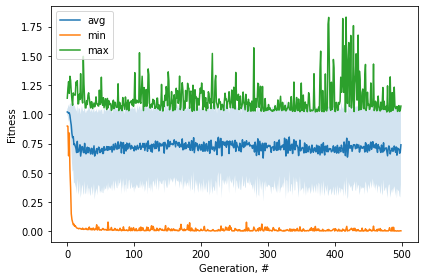

best
[ 0.00480472 -0.01567369 -0.0040409  -0.06796117  0.01446546 -0.0125124
 -0.02866348  0.06317228 -0.00219182 -0.0162178 ]
speed
[-0.35103037 -0.19788996  0.3872119   0.43083913  1.88036064 -0.97036848
 -0.14782314  0.14228114  0.70969021  0.4340127 ]


In [109]:
pso_exp = PSOAlgorithm(pop_size, iterations, dimension, optimization_function)
pop, logbook, best = pso_exp.run()
print("best")
print(best)
print("speed")
print(pop[0].speed)

# 3. Сравнение эффективностей алгоритмов

gen	nevals	avg    	std      	min     	max    
0  	100   	1.02077	0.0181553	0.906489	1.09017
1  	80    	1.0067 	0.0239642	0.906489	1.02385
2  	80    	0.986471	0.0369687	0.906482	1.01643
3  	80    	0.949948	0.0436651	0.858099	1.01012
4  	80    	0.900729	0.0426549	0.786206	1.00222
5  	80    	0.853215	0.0444867	0.717992	0.930424
6  	80    	0.804899	0.0455205	0.717992	0.920218
7  	80    	0.749346	0.0341656	0.683717	0.836137
8  	80    	0.705638	0.0349912	0.619828	0.791419
9  	80    	0.669648	0.032532 	0.603326	0.755825
10 	80    	0.635626	0.0238515	0.584022	0.688399
11 	80    	0.615154	0.0205067	0.572507	0.665565
12 	80    	0.590079	0.022494 	0.526005	0.634185
13 	80    	0.561574	0.0248268	0.502664	0.603326
14 	80    	0.53634 	0.024572 	0.489988	0.587802
15 	80    	0.516478	0.0244567	0.468994	0.602336
16 	80    	0.495119	0.0168014	0.4525  	0.534134
17 	80    	0.475431	0.0188691	0.427265	0.507922
18 	80    	0.457972	0.0157649	0.426149	0.496962
19 	80    	0.447518	0.0139944	0.426149	0.496962
2

172	80    	0.394899	0.00388451 	0.394163	0.422061
173	80    	0.394163	5.55112e-17	0.394163	0.394163
174	80    	0.394286	0.00121691 	0.394163	0.406394
175	80    	0.394638	0.00361547 	0.394163	0.427971
176	80    	0.394712	0.00386556 	0.394163	0.4246  
177	80    	0.394912	0.00425471 	0.394163	0.419233
178	80    	0.395307	0.00480032 	0.394163	0.421145
179	80    	0.395755	0.00689188 	0.394163	0.442645
180	80    	0.395368	0.00600822 	0.394163	0.432647
181	80    	0.394978	0.00430601 	0.394163	0.42478 
182	80    	0.394733	0.00317353 	0.394163	0.421507
183	80    	0.395213	0.0042418  	0.394163	0.414733
184	80    	0.394889	0.00323188 	0.394163	0.414297
185	80    	0.395628	0.00815904 	0.394163	0.458851
186	80    	0.395063	0.00561414 	0.394163	0.440963
187	80    	0.394585	0.00311826 	0.394163	0.422387
188	80    	0.394412	0.00178659 	0.394163	0.409479
189	80    	0.394524	0.00253071 	0.394163	0.413337
190	80    	0.39444 	0.00196751 	0.394163	0.410544
191	80    	0.394423	0.00183114 	0.394163	0.408848


339	80    	0.395924	0.00600836 	0.394138	0.423994
340	80    	0.394741	0.00350031 	0.394138	0.418973
341	80    	0.394864	0.00368886 	0.394138	0.418973
342	80    	0.394565	0.00301764 	0.394138	0.418365
343	80    	0.394759	0.00593074 	0.394138	0.453743
344	80    	0.394753	0.00446785 	0.394138	0.433318
345	80    	0.39518 	0.00563972 	0.394138	0.433204
346	80    	0.394348	0.00150565 	0.394138	0.406844
347	80    	0.394833	0.00490386 	0.394138	0.432958
348	80    	0.395843	0.00610168 	0.394138	0.425076
349	80    	0.394447	0.00239456 	0.394138	0.416847
350	80    	0.395599	0.0100832  	0.394138	0.492094
351	80    	0.394627	0.00372068 	0.394138	0.4289  
352	80    	0.394479	0.00266525 	0.394138	0.419569
353	80    	0.3943  	0.0016198  	0.394138	0.410417
354	80    	0.394283	0.001451   	0.394138	0.408721
355	80    	0.395076	0.00534746 	0.394138	0.426976
356	80    	0.394594	0.00264313 	0.394138	0.412382
357	80    	0.394389	0.00250436 	0.394138	0.419307
358	80    	0.394722	0.00297229 	0.394138	0.414885


1  	100  	1.0136 	0.0487363	0.633832	1.19294
2  	100  	1.00742	0.119839 	0.410364	1.47328
3  	100  	1.02944	0.0747378	0.841344	1.37217
4  	100  	0.958637	0.131406 	0.386114	1.35389
5  	100  	0.924295	0.159952 	0.438157	1.20642
6  	100  	0.888276	0.188318 	0.314934	1.12208
7  	100  	0.863916	0.200113 	0.362756	1.1698 
8  	100  	0.787839	0.25649  	0.245516	1.25786
9  	100  	0.753858	0.269856 	0.215104	1.11132
10 	100  	0.758556	0.255445 	0.167477	1.08572
11 	100  	0.709755	0.311762 	0.148488	1.0808 
12 	100  	0.722133	0.304355 	0.151754	1.08405
13 	100  	0.713415	0.295824 	0.139882	1.06388
14 	100  	0.68667 	0.305484 	0.123671	1.08812
15 	100  	0.667136	0.328354 	0.105219	1.05704
16 	100  	0.656351	0.312541 	0.122821	1.07777
17 	100  	0.64544 	0.311196 	0.112384	1.08219
18 	100  	0.68474 	0.316907 	0.109357	1.06725
19 	100  	0.629182	0.343336 	0.105327	1.12664
20 	100  	0.627345	0.325396 	0.120385	1.11774
21 	100  	0.665078	0.341126 	0.107707	1.05289
22 	100  	0.671224	0.326384 	0.104463

177	100  	0.716963	0.315992 	0.0143114	1.19388
178	100  	0.67395 	0.348697 	0.0460296	1.10792
179	100  	0.725619	0.321654 	0.04583  	1.43207
180	100  	0.734048	0.343092 	0.0424935	1.33455
181	100  	0.714727	0.319498 	0.0330528	1.09449
182	100  	0.704638	0.317479 	0.0874361	1.38391
183	100  	0.730107	0.322941 	0.05407  	1.08083
184	100  	0.759632	0.315122 	0.038322 	1.07724
185	100  	0.712464	0.335681 	0.0312626	1.04798
186	100  	0.723111	0.333347 	0.0571828	1.19408
187	100  	0.763239	0.305289 	0.0390588	1.16403
188	100  	0.73524 	0.309283 	0.0364584	1.06726
189	100  	0.726533	0.294615 	0.0211033	1.06643
190	100  	0.715623	0.342358 	0.0544908	1.22094
191	100  	0.777691	0.29823  	0.0215936	1.14224
192	100  	0.740311	0.309229 	0.0319233	1.04477
193	100  	0.741148	0.330376 	0.0530222	1.10149
194	100  	0.733722	0.314046 	0.0454571	1.28156
195	100  	0.705005	0.318337 	0.066325 	1.06809
196	100  	0.732837	0.318176 	0.0646202	1.18691
197	100  	0.744734	0.333937 	0.0243494	1.1465 
198	100  	0.7

366	100  	0.758516	0.313259 	0.018363 	1.10767
367	100  	0.747087	0.315859 	0.0522992	1.25801
368	100  	0.75494 	0.29924  	0.0617469	1.2704 
369	100  	0.732298	0.338755 	0.0438623	1.24693
370	100  	0.710846	0.326017 	0.0470929	1.06697
371	100  	0.754189	0.304963 	0.011412 	1.09417
372	100  	0.756574	0.296875 	0.0457865	1.12397
373	100  	0.708911	0.339119 	0.0861672	1.06646
374	100  	0.750481	0.289936 	0.0527564	1.15198
375	100  	0.744482	0.333525 	0.0179168	1.27724
376	100  	0.745507	0.327259 	0.0292904	1.22375
377	100  	0.733874	0.305722 	0.0315955	1.06069
378	100  	0.71053 	0.335618 	0.0191317	1.29816
379	100  	0.766644	0.319533 	0.0270784	1.57977
380	100  	0.742316	0.338482 	0.0387749	1.51897
381	100  	0.730433	0.325389 	0.0338039	1.07468
382	100  	0.717454	0.328229 	0.0367232	1.21993
383	100  	0.720388	0.362518 	0.0413917	1.3768 
384	100  	0.741681	0.33056  	0.0171751	1.1455 
385	100  	0.750402	0.276666 	0.0253101	1.18175
386	100  	0.690359	0.339178 	0.0308767	1.61716
387	100  	0.7

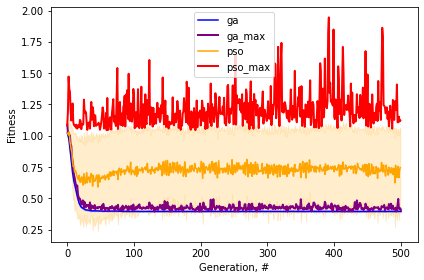

In [110]:
dimension = 10
pop_size = 100
iterations = 500
ga = GeneticAlgorithm(factory, optimization_function, pop_size, mutation = Mymutation, dimension=dimension)
population, log = ga.run_evolution(cross_prob, mut_prob, iterations, verbose=False)

pso = PSOAlgorithm(pop_size, iterations, dimension, optimization_function)
pop, logbook, best = pso.run(verbose=False)
DrawLog.draw_logs(log, logbook, "ga", "pso")